In [1]:
%load_ext jupyternotify

import numpy as np
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary

env = gym.make('MountainCar-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend() # checks if one is running IPhyton environment like jupyter notebook
if is_ipython:
    from IPython import display

plt.ion() # interactive mode on, allows automatic plots when data is updated (whithout calling plt.show every time)

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Is it necessary to implement an "observe(self, state, action, next_state, reward)" function, called upon observing a new transition of the environment?

class ReplayBuffer(object):

    def __init__(self, capacity):
        self.buffer = deque([], maxlen=capacity)
    # Compute a mask of non-final states and concatenate the batch elements

    def push(self, *args):
        """Save a transition"""
        self.buffer.append(Transition(*args))   # need *args because Transition expects values when instantiated

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, n_nodes_per_layer=64, n_layers=2):
        super(DQN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(n_observations, n_nodes_per_layer)])
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(n_nodes_per_layer, n_nodes_per_layer))
        self.output_layer = nn.Linear(n_nodes_per_layer, n_actions)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)

BATCH_SIZE = 128 # BATCH_SIZE is the number of transitions sampled from the replay buffer, chosen according to advise from slides
GAMMA = 0.99 # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9 # EPS_START is the starting value of epsilon, chosen according to advise from slides
EPS_END = 0.1 # EPS_END is the final value of epsilon, chosen according to advise from slides
EPS_DECAY = 100000 # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay. EPS_DECAY = 100000 decays to 0.1 after 1000000 steps
TAU = 0.0005 # TAU is the update rate of the target network... for tau = 0.0001: 0.0001 * 200 steps * 50 episodes = update frequency of 10000, as suggested in slides
LR = 1e-4 # LR is the learning rate of the ``AdamW`` optimizer

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)
#n_nodes_per_layer=80   BY DEFAULT 64
#n_layers=4         BY DEFAULT 2

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  # initiate target net with parameters of policy net
         
# check if DQN is doing what it should
#summary(policy_net, (128,2)) ### input size = (128, 2) = (batch_size, nr_observations)

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)  # optimize policy_net.parameters through backprop and later "softly" update target net parameters
buffer = ReplayBuffer(10000) # recommended capacity = 10000 , if too small (<1000) it will learn too slowly


steps_done = 0


def select_action(state):
    global steps_done   #global variable: any changes made to steps_done within the function select_action will affect the variable defined outside the function's scope
    rand_num = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if rand_num > eps_threshold:
        with torch.no_grad():
            # t.max(1) finds max value along second dimension (action space)
            # .indices returns index of max values
            # .view() reshapes index into desired format
            return policy_net(state).max(1).indices.view(1, 1)      # select action with maximum expected reward
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
                # choose random action sampling from environment's action space with env.action_space.sample(), then transform into pytorch tensor

episode_durations = []

<IPython.core.display.Javascript object>

In [2]:
def plot_durations(title, savefig=False, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title(title)
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label = 'Durations')
    # Take 100 episode averages and plot them too
    if len(durations_t) > 100:
        means = durations_t[100:].unfold(0, 100, 1).mean(1).view(-1) #calculates the 100-episode moving averages of the durations
        #means = torch.cat((torch.zeros(99), means))
        plt.plot(range(100, len(episode_durations)-99), means.numpy(), label='Moving Average (100 episodes)')
    if savefig: 
        plt.savefig(f"{title}.png", dpi=300) # Use f-string to concatenate strings and variable

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [3]:
def update_model():
    if len(buffer) < BATCH_SIZE:
        return # returns nothing, if buffer smaller than batch size, i.e. model is not optimized!

    transitions = buffer.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions)) # i.e. zip(*[('a', 1), ('b ', 2), ('c', 3), ('d', 4)]) = [('a', 'b', 'c', 'd'), (1, 2, 3, 4)]

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool) #checks each next_state in the minibatch (batch.next_state) and evaluates whether it is not "None"., if not "none" then episode not terminate, i.e. no final state. response = boolean (true, false)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]) #iterates through each next_state in the minibatch, and if the next_state is not "None" (i.e. non final), it adds it to the list comprehension
    state_batch = torch.cat(batch.state) #concatenates the states from the minibatch (batch.state) into a single tensor (state_batch)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # Each row of the output corresponds to the Q-values for one state of the batch..gather(1, action_batch) selects elements from each row of the Q-values tensor according to the indices specified in action_batch. This operation effectively selects the Q-values for the actions that were taken in each state.

    # Compute Q(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values   #next_state_values[non_final_mask] selects elements from next_state_values at positions where non_final_mask is True
        # the idea is that your policy_network learns some q values and gets updated each episode while target network only gets updated once in a while, where its parameters become closer to the policy network. Therefore the target network is slowly dragged towards the parameters of the policy network, which finally results in learning
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    expected_state_action_values = expected_state_action_values.float()

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    #criterion = nn.MSELoss()  # try mse
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) # unsqueeze to add another dimension (batch dimension) to process it well with rest)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()  # Return the loss value as a scalar

In [7]:
%%notify

if torch.cuda.is_available():
    num_episodes = 3000       #run for 1000 episodes and see if agent solves the task
else:
    num_episodes = 3000

loss_per_episode = []
cumulative_reward_per_episode = []
cumulative_environment_reward_per_episode = []
cumulative_auxiliary_reward_per_episode = []
nr_steps = 0
agent_performance = [] # list of zeros and ones

for i_episode in tqdm(range(num_episodes), desc="Episodes"):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)

    cumulative_reward_t = 0
    environment_reward_t = 0
    auxiliary_reward_t = 0
    running_loss = []

    for t in count():

        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item()) #in colab no _
        environment_reward_t += reward
        
        #auxiliary reward:
        aux_reward = 0.001*observation[0] #could also do observation[1] for reward connected to velocity
        
        auxiliary_reward_t += aux_reward
        reward = reward + aux_reward # try this asymmetric large aux. reward for 3000 episodes!

        # or try something like penalizing the car for staying in the valley center:
        # if abs(observation[0]) < 0.01:
        #   reward = reward - 1

        cumulative_reward_t += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
            agent_performance.append(1)
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        if truncated:
            agent_performance.append(0)
            
        # Store the transition in memory
        buffer.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        #update_model()
        loss_value = update_model()
        
        #========================= Target net update =============================
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # Either a) soft update or b) hard update

        # a) Soft update of the target network's weights every C = 10000 steps (= 50*t, if t = 200)
        # θ′ ← τ θ + (1 −τ )θ′

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # b) Hard update of target network every 10000 steps
#         nr_steps += 1
#         if nr_steps % 10000 == 0:
#           for key in policy_net_state_dict:
#             target_net_state_dict[key] = policy_net_state_dict[key]
#           target_net.load_state_dict(target_net_state_dict)
        #=========================================================================

        if done: 
            episode_durations.append(t + 1)
            #plot_durations()
            break

        running_loss.append(loss_value)
    
    # Ensure running_loss is not empty before computing mean
    if running_loss:
        loss_per_episode.append(np.mean(running_loss)) #creates error when running it the first time, but works when running it the second time
    cumulative_reward_per_episode.append(cumulative_reward_t)
    cumulative_environment_reward_per_episode.append(environment_reward_t)
    cumulative_auxiliary_reward_per_episode.append(auxiliary_reward_t)

Episodes: 100%|█████████████████████████████| 3000/3000 [15:05<00:00,  3.31it/s]


<IPython.core.display.Javascript object>

## TASK:
run agent with aux. reward for 3000 episodes. does it solve the task? what happens for very small/large aux. rewards? optimize parameers such that you can solve in less than a thousand episodes.



### NOTES:

- aux. reward does not learn for 1000 episodes -> try for 3000 episodes.
- try very small/large aux. rewards (small(=0.5)/large(=3): no success. very small(= velocity):success!)
- since loss increases parabolically maybe try tweaking tau
- check whether soft or hard update works better (only soft leads to success rn)
- try symmetric and asymmetric aux. reward again for 3000 episodes
- trying MSE Loss
- maybe implement aux reward that heavily penalizes lowest state, which then leads to the car staying away from the lowest state as long as possible by doing longer and longer oscillations)
- it would be interesting to plot maximum position per episode

In [8]:
### Plotting functions, and "cumulation" function

def plot_curve(data, title, xlabel, ylabel, savefig=False):
    plt.plot(data, label = 'title')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if savefig: 
        plt.savefig(f"{title}.png", dpi=300) # Use f-string to concatenate strings and variable
        
def plot_scatter(data, xlabel, ylabel):
    data_t = torch.tensor(data, dtype=torch.float)
    plt.title('Result')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(list(range(len(data))), data_t.numpy()) # usually for plt.scatter you need (x,y) as arguments

def plot_with_average(data, xlabel, ylabel):
    plt.figure(1)
    data_t = torch.tensor(data, dtype=torch.float)
    plt.title('Result')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(list(range(len(data))), data_t.numpy(), label='Cumulative Reward Per Episode') 
    # Take 100 episode averages and plot them too
    if len(data_t) > 100:  # Check if data has more than 100 episodes
        # Calculate moving average starting from episode 100
        means = data_t[100:].unfold(0, 100, 1).mean(1).view(-1)
        # Plot the average line starting from episode 100
        plt.plot(range(100, len(data)-99), means.numpy(), label='Moving Average (100 episodes)')


def cumulative_sum(input_list):
    result = []
    running_total = 0
    for element in input_list:
        running_total += element
        result.append(running_total)
    return result

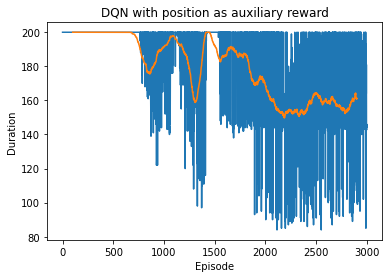

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
#============ Duration per Episode =====================

figure_title = 'DQN with position as auxiliary reward' # = filename
plot_durations(figure_title, savefig=True, show_result=True)
#plt.ioff()

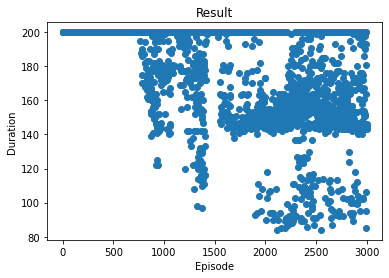

In [10]:
#============ Episode Durations, Scatterplot =====================

plot_scatter(episode_durations, 'Episode', 'Duration')
plt.show()

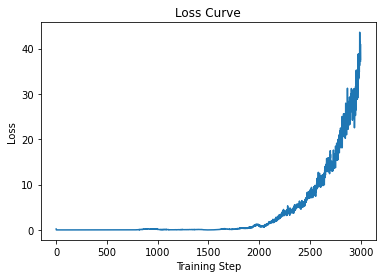

final loss: 37.23549823358025
average_cumulative_reward_per_episode =  -180.1157176609905


In [11]:
#============ Loss Curve =====================

plot_curve(loss_per_episode, 'Loss Curve', 'Training Step', 'Loss')
plt.show()

# report loss
print("final loss:", loss_per_episode[-1])

# report average cumulative reward per ep
average_cumulative_reward_per_episode = np.mean(cumulative_reward_per_episode)
print('average_cumulative_reward_per_episode = ', average_cumulative_reward_per_episode)


# IT CAN HAPPEN THAT INITIALLY LOSS CURVE GOES UP WHILE DURATIONS CURVE GOES DOWN. BECAUSE WHEN THE AGENT FINDS WAYS OF SOLVING THE TASK FASTER (DURATION GOES DOWN), THE LOSS FUNCTION IS BIG BECAUSE IT DOES NOT PREDICT THE REWARDS THAT THE AGENT IS FINDING. IN THE END LOSS SHOULD DECREASE HOWEVER

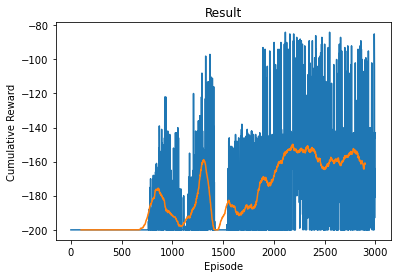

In [12]:
#============ Cumulative Reward per Episode =====================

plot_with_average(cumulative_reward_per_episode, 'Episode', 'Cumulative Reward')

### THIS PLOT IS (ALMOST) LIKE THE DURATIONS PLOT BUT FLIPPED

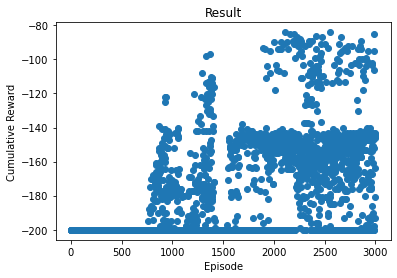

In [13]:
#============ Cumulative Reward per Episode, Scatterplot =====================

plot_scatter(cumulative_reward_per_episode, 'Episode', 'Cumulative Reward')
plt.show()

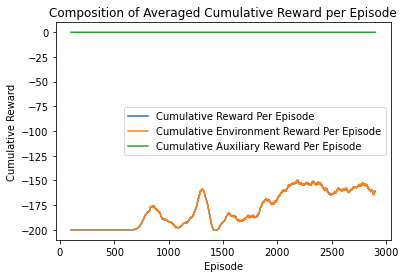

In [14]:
#============ Composition of Averaged Cumulative Reward per Episode =====================

data_t = torch.tensor(cumulative_reward_per_episode, dtype=torch.float)
plt.title('Composition of Averaged Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
c_e_r_p_e_t = torch.tensor(cumulative_environment_reward_per_episode, dtype=torch.float)
c_a_r_p_e_t = torch.tensor(cumulative_auxiliary_reward_per_episode, dtype=torch.float)
if len(c_e_r_p_e_t) > 100:  # Check if data has more than 100 episodes
        means = data_t[100:].unfold(0, 100, 1).mean(1).view(-1)
        # Plot the average line starting from episode 100
        plt.plot(range(100, len(cumulative_reward_per_episode)-99), means.numpy(), label='Cumulative Reward Per Episode')
        # Calculate moving average starting from episode 100
        means = c_e_r_p_e_t[100:].unfold(0, 100, 1).mean(1).view(-1)
        # Plot the average line starting from episode 100
        plt.plot(range(100, len(cumulative_environment_reward_per_episode)-99), means.numpy(), label='Cumulative Environment Reward Per Episode')
        means = c_a_r_p_e_t[100:].unfold(0, 100, 1).mean(1).view(-1)
        # Plot the average line starting from episode 100
        plt.plot(range(100, len(cumulative_auxiliary_reward_per_episode)-99), means.numpy(), label='Cumulative Auxiliary Reward Per Episode')

plt.legend()
plt.show()

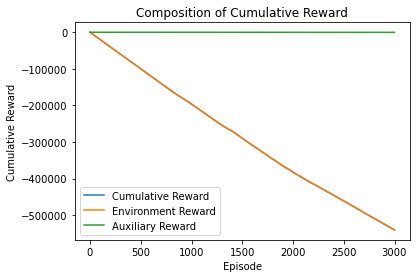

In [15]:
#============ Cumulative number of successes per Episode =====================

cumulative_reward = cumulative_sum(cumulative_reward_per_episode)
cumulative_environment_reward = cumulative_sum(cumulative_environment_reward_per_episode)
cumulative_auxiliary_reward = cumulative_sum(cumulative_auxiliary_reward_per_episode)

#separately depict the environment reward, the auxiliary reward and their sum
#### SMOOTHEN IF NECESSARY
plt.figure(1)
plt.title('Composition of Cumulative Reward')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.plot(cumulative_reward, label='Cumulative Reward')
plt.plot(cumulative_environment_reward, label='Environment Reward')
plt.plot(cumulative_auxiliary_reward, label='Auxiliary Reward')

plt.legend()  # Show legend


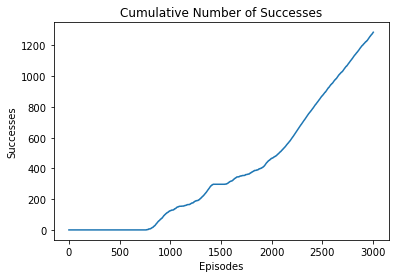

In [17]:
#============ Cumulative number of successes =====================

cumulative_successes = cumulative_sum(agent_performance)
plot_curve(cumulative_successes, 'Cumulative Number of Successes', 'Episodes', 'Successes', savefig=False)